## <u>Notebook Synopsis</u>:
In this notebook, I develop the "main" dataset, stored in a dataframe, created in the previous notebook. These development steps include:
* Compute a max(blue)-to-green ratio (MBR.)
* Log-transform rrs, chl and MBR data.
* Compute Color Index (CI, [Hu et al. 2012](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011JC007395))
* apply a set of criteria making this dataset amenable to an OCI type model - *cf.*
[(Hu et al. 2012)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011JC007395) - as well as for the other models to be tested in this study; create a flag, 'CI_OK' indicating suitability for use in OCI.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sb
from yellowbrick.features import JointPlotVisualizer
import matplotlib.pyplot as pl

In [4]:
pl.style.use('seaborn-dark-palette')

Load the 'main' dataset:

In [5]:
df = pd.read_pickle('./pickleJar/df_main.pkl')

In [6]:
df.head()

,id,etopo2,lat,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,chlor_a,is_hplc
0,1565,0.0,38.4279,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,38.19,False
1,1566,0.0,38.3680,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,35.01,False
2,1567,1.0,38.3074,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,26.91,False
3,1568,3.0,38.6367,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,47.96,False
4,1559,1.0,38.3047,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,23.55,False


\\(\rightarrow \\) Replace '0' values to avoid underflow

In [7]:
df.replace(0, 1e-10, inplace=True)

In [8]:
df.describe()

,id,etopo2,lat,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,chlor_a
count,4459.000000,4.459000e+03,4459.000000,4293.000000,4456.000000,4422.000000,3435.000000,3255.000000,1.598000e+03,4127.000000
mean,4377.381251,1.312347e+03,1.868658,0.004881,0.004652,0.004590,0.004130,0.003256,1.557001e-03,2.680228
std,2298.272102,1.766435e+03,44.765125,0.003447,0.003002,0.002768,0.003130,0.003536,2.386548e-03,5.758436
min,6.000000,1.000000e-10,-77.035600,0.000051,0.000190,0.000284,0.000261,0.000183,1.000000e-10,0.012000
25%,2028.500000,1.800000e+01,-61.299000,0.002509,0.002617,0.003051,0.002831,0.001588,1.998352e-04,0.233325
50%,5039.000000,2.400000e+02,27.093000,0.003984,0.003899,0.004153,0.003425,0.002071,6.136641e-04,0.764000
75%,6271.500000,2.789500e+03,34.458500,0.006301,0.006076,0.005655,0.004242,0.003141,2.000334e-03,2.150000
max,7831.000000,7.978000e+03,79.690000,0.030600,0.036769,0.063814,0.077740,0.046600,2.769998e-02,77.864800


Create a new column to receive a color index (hereafter 'CI') value according to [Hu *et al.*, 2012](http://dx.doi.org/10.1029/2011jc007395)):

In [9]:
df.insert(df.shape[1]-2, 'CI',
          df.rrs555 - (df.rrs443
                       + (555-443) / (670-443)
                       * (df.rrs670 - df.rrs443)))

CI criteria for NOMAD (from [Hu *et al.*, 2012](http://dx.doi.org/10.1029/2011jc007395)):
* chl from hplc
* Rrs($\lambda$) > 0.0 sr^{-1}
* Chl > 0.0
* bottom depth > 30.0m
* latitude $\in$ [60$^\circ$S, 60$^\circ$N] 

Create a new column to receive boolean 'CI' validation flag.

In [10]:
df.insert(df.columns.get_loc('CI')+1, 'CI_valid', 1)

Implement criteria

In [11]:
df.loc[((~df.is_hplc) | (df.rrs670<=0) |
       (df.chlor_a<=0) | (df.etopo2<=30) | (df.lat<-60) | 
       (df.lat>60)), 'CI_valid'] = 0

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,4459.0,4377.381251,2298.272102,6.000000e+00,2028.500000,5039.000000,6271.500000,7831.000000
etopo2,4459.0,1312.346715,1766.435289,1.000000e-10,18.000000,240.000000,2789.500000,7978.000000
lat,4459.0,1.868658,44.765125,-7.703560e+01,-61.299000,27.093000,34.458500,79.690000
rrs411,4293.0,0.004881,0.003447,5.120683e-05,0.002509,0.003984,0.006301,0.030600
rrs443,4456.0,0.004652,0.003002,1.900331e-04,0.002617,0.003899,0.006076,0.036769
rrs489,4422.0,0.004590,0.002768,2.840986e-04,0.003051,0.004153,0.005655,0.063814
rrs510,3435.0,0.004130,0.003130,2.611592e-04,0.002831,0.003425,0.004242,0.077740
rrs555,3255.0,0.003256,0.003536,1.832046e-04,0.001588,0.002071,0.003141,0.046600
rrs670,1598.0,0.001557,0.002387,1.000000e-10,0.000200,0.000614,0.002000,0.027700
CI,1163.0,0.002061,0.003488,-6.577728e-03,0.000274,0.001315,0.003598,0.023865


A 'CI' threshold of -0.0005 is used as further criterion for CI applicability. Next is to create a column to 

In [13]:
ci_thresh = -0.0005
df.insert(df.shape[1]-2, 'within_CI_thresh',
          df.CI<ci_thresh)

In [14]:
df.within_CI_thresh = df.within_CI_thresh.astype('i')

In [15]:
df.head()

,id,etopo2,lat,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,CI,CI_valid,within_CI_thresh,chlor_a,is_hplc
0,1565,1.000000e-10,38.4279,0.001204,0.001686,0.003293,0.004036,0.007479,0.003465,0.004916,0,0,38.19,False
1,1566,1.000000e-10,38.3680,0.001062,0.001384,0.002173,0.002499,0.004152,0.001695,0.002615,0,0,35.01,False
2,1567,1.000000e+00,38.3074,0.000971,0.001185,0.001843,0.002288,0.004246,0.001612,0.002850,0,0,26.91,False
3,1568,3.000000e+00,38.6367,0.001472,0.001741,0.002877,0.003664,0.006982,0.003234,0.004504,0,0,47.96,False
4,1559,1.000000e+00,38.3047,0.000905,0.001022,0.001506,0.001903,0.002801,0.001791,0.001399,0,0,23.55,False


Numbers of threshold-satisfying rows

In [16]:
df.within_CI_thresh.value_counts()

0    4217
1     242
Name: within_CI_thresh, dtype: int64

Numbers of CI-valid rows with satisfied threshold requirements

In [17]:
df.loc[df.CI_valid==1, 'within_CI_thresh'].value_counts()

0    914
1     50
Name: within_CI_thresh, dtype: int64

In [18]:
df.insert(df.shape[1]-2, 'CI_OK',
          df.CI_valid * df.within_CI_thresh)

Verify the 'CI_OK' column is actually OK, i.e. according to the above there should be 50 rows with a value of '1':

In [19]:
df.CI_OK.value_counts()

0    4409
1      50
Name: CI_OK, dtype: int64

Now I can drop the first two CI columns

In [20]:
df.drop(['CI_valid', 'within_CI_thresh'], axis=1, inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4459 entries, 0 to 4458
Data columns (total 13 columns):
id         4459 non-null int64
etopo2     4459 non-null float64
lat        4459 non-null float64
rrs411     4293 non-null float64
rrs443     4456 non-null float64
rrs489     4422 non-null float64
rrs510     3435 non-null float64
rrs555     3255 non-null float64
rrs670     1598 non-null float64
CI         1163 non-null float64
CI_OK      4459 non-null int64
chlor_a    4127 non-null float64
is_hplc    4459 non-null bool
dtypes: bool(1), float64(10), int64(2)
memory usage: 422.5 KB


Define some functions for feature transformations:

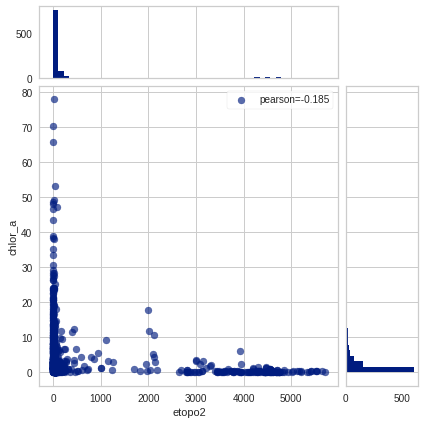

In [23]:
f, ax = pl.subplots(figsize=(6,6))
jointviz = JointPlotVisualizer(columns=["etopo2", "chlor_a"], ax=ax)
jointviz.fit_transform(df.dropna())
jointviz.poof()

The above suggests depth (etopo2) should be log-transformed, the same as chlor_a:

In [24]:
def insert_MBR(df_):
    """Compute max Blue-to-Green Ratio.
    Takes a dataframe as argument.
    Modifies dataframe by adding columns containing
        'MaxBlue'- related information (3 columns)
        'MaxBlue-to-Green' Ratio (1) column
    """
    insert_loc = df_.columns.get_loc('chlor_a')
    blue_cols = ['rrs443', 'rrs489', 'rrs510']
    df_.insert(insert_loc, 'MaxBlue', df_[blue_cols].max(axis=1))
    insert_loc += 1
    df_.insert(insert_loc, 'MaxBlueBand', df_[blue_cols].idxmax(axis=1).str.capitalize())
    insert_loc += 1
    df_.insert(insert_loc,'MaxBlueBandIdx',
               pd.Categorical(df_.MaxBlueBand, categories=[bluecol.capitalize() for bluecol in blue_cols]).codes)
    insert_loc += 1
    df_.insert(insert_loc, 'mxBlue2Gr', df_.MaxBlue / df_.rrs555)
    
    
def log_transform_for_chl_model(df_, merge=False):
    """
    Log-transforms columns returned by the regex query searching for 'rrs', 'chl', 'mxBlue2.'
    If 'merge' is True, log-transformed columns are added to the original dataframe
    """
    columns_to_log_transform = df_.filter(regex='(etopo2|rrs|chl|mxBlue2)',
                                             axis=1).columns.tolist()
    df_[columns_to_log_transform].replace(0, 1e-10, inplace=True)
    if merge:
        for col in columns_to_log_transform:
            df_.insert(df_.columns.get_loc(col)+1,
                      f'log_{col}', np.log10(df.loc[:, col]))
        return None
    else:
        # log_transforms
        df_log = pd.DataFrame(np.log10(df_.loc[:,
                                               columns_to_log_transform
                                              ].values),
                              columns=[f'log_{col}' 
                                       for col in columns_to_log_transform])
        return df_log

In [25]:
insert_MBR(df)

In [26]:
log_transform_for_chl_model(df, merge=True)

/accounts/ekarakoy/anaconda3/envs/probaprog/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


In [28]:
df.describe()

,id,etopo2,log_etopo2,lat,rrs411,log_rrs411,rrs443,log_rrs443,rrs489,log_rrs489,...,rrs670,log_rrs670,CI,CI_OK,MaxBlue,MaxBlueBandIdx,mxBlue2Gr,log_mxBlue2Gr,chlor_a,log_chlor_a
count,4459.000000,4.459000e+03,4459.000000,4459.000000,4293.000000,4293.000000,4456.000000,4456.000000,4422.000000,4422.000000,...,1.598000e+03,1598.000000,1163.000000,4459.000000,4459.000000,4459.000000,3255.000000,3255.000000,4127.000000,4127.000000
mean,4377.381251,1.312347e+03,1.820020,1.868658,0.004881,-2.419273,0.004652,-2.421040,0.004590,-2.395443,...,1.557001e-03,-3.501395,0.002061,0.011213,0.005277,0.843014,2.469670,0.278669,2.680228,-0.112459
std,2298.272102,1.766435e+03,2.692464,44.765125,0.003447,0.326394,0.003002,0.292499,0.002768,0.224659,...,2.386548e-03,1.625059,0.003488,0.105309,0.003407,0.802378,1.900472,0.310451,5.758436,0.687956
min,6.000000,1.000000e-10,-10.000000,-77.035600,0.000051,-4.290672,0.000190,-3.721171,0.000284,-3.546531,...,1.000000e-10,-10.000000,-0.006578,0.000000,0.000284,0.000000,0.399575,-0.398402,0.012000,-1.920819
25%,2028.500000,1.800000e+01,1.255273,-61.299000,0.002509,-2.600448,0.002617,-2.582159,0.003051,-2.515600,...,1.998352e-04,-3.699328,0.000274,0.000000,0.003148,0.000000,1.048960,0.020759,0.233325,-0.632039
50%,5039.000000,2.400000e+02,2.380211,27.093000,0.003984,-2.399659,0.003899,-2.409061,0.004153,-2.381635,...,6.136641e-04,-3.212071,0.001315,0.000000,0.004427,1.000000,1.690559,0.228030,0.764000,-0.116907
75%,6271.500000,2.789500e+03,3.445526,34.458500,0.006301,-2.200602,0.006076,-2.216361,0.005655,-2.247581,...,2.000334e-03,-2.698897,0.003598,0.000000,0.006617,2.000000,3.424486,0.534595,2.150000,0.332438
max,7831.000000,7.978000e+03,3.901894,79.690000,0.030600,-1.514280,0.036769,-1.434521,0.063814,-1.195083,...,2.769998e-02,-1.557521,0.023865,1.000000,0.077740,2.000000,10.239706,1.010287,77.864800,1.891341


Inspect the 'CI', log ratio and log chlorophyll data, conditioned on CI validity:

In [34]:
df.dropna().CI_OK.value_counts()

0    1002
1      50
Name: CI_OK, dtype: int64

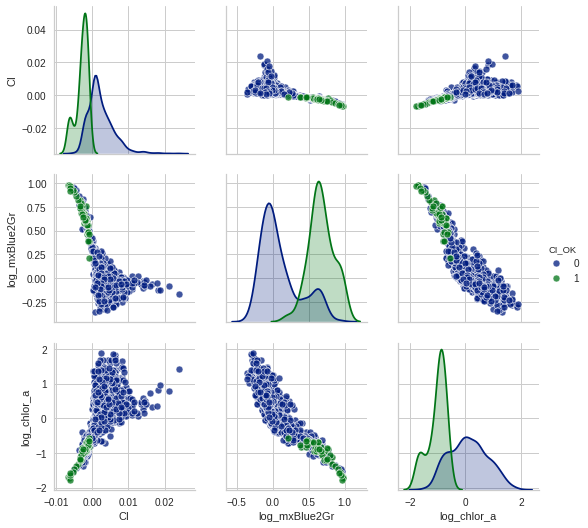

In [30]:
sb.pairplot(df.dropna(), hue='CI_OK',
           vars=['CI', 'log_mxBlue2Gr', 'log_chlor_a'],
            plot_kws={'alpha':0.75,});
f_ = pl.gcf()

In [31]:
df.to_pickle('./pickleJar/df_main_2_w_CI.pkl')

--- 
End of this notebook.